<a href="https://colab.research.google.com/github/abdulxs/Eye-Tracking/blob/main/Gaze%20Events%20Detection/implement_HMM_event_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Template adapted from Jani Koskinen


## Load prerequisites

Import some required libraries

In [2]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

Load eye tracking data from the Jenga experiment. If you are running this locally, comment out/remove the !wget line and change to path to the pd.read_csv function (if you only exctracted the zip, the file should be in 'data/jenga-clip-data.csv').


In [81]:
#!wget 'https://raw.githubusercontent.com/jpkos/ET_UEF/main/data/jenga-clip-data.csv'
df = pd.read_csv('/content/jenga-clip-data.csv.2') #Change path if running locally e.g. with jupyterlab
pd.options.display.max_columns = None
display(df.head(n=6))
print(f'Size of dataframe: {df.shape[0]} rows and {df.shape[1]} columns.')

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,Recording start time UTC,Recording duration,Recording Fixation filter name,Event,Event value,Gaze point X,Gaze point Y,Gaze point 3D X,Gaze point 3D Y,Gaze point 3D Z,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,Gaze direction right X,Gaze direction right Y,Gaze direction right Z,Pupil position left X,Pupil position left Y,Pupil position left Z,Pupil position right X,Pupil position right Y,Pupil position right Z,Pupil diameter left,Pupil diameter right,Validity left,Validity right,Recording media name,Recording media width,Recording media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Gyro X,Gyro Y,Gyro Z,Accelerometer X,Accelerometer Y,Accelerometer Z
0,1100933,212005972,Accelerometer,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,-10591.0,-93956.0,33621.0
1,1101814,212006853,Gyroscope,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,207900.0,-13841.0,-94844.0,NaN,NaN,NaN
2,1109375,212014414,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,938.0,551.0,140557.0,-2544.0,3638614.0,-3412.0,8184.0,99606.0,11310.0,4213.0,99269.0,2963.0,-2629.0,-3652.0,-3303.0,-2394.0,-3312.0,589.0,542.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1110754,212015793,Accelerometer,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,-11376.0,-94729.0,33485.0
4,1112695,212017734,Gyroscope,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,198100.0,-10759.0,-92168.0,NaN,NaN,NaN
5,1119370,212024409,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,938.0,548.0,141454.0,5366.0,3650480.0,-3486.0,7989.0,99619.0,11433.0,4725.0,99232.0,2928.0,-2639.0,-3655.0,-3294.0,-2368.0,-3307.0,595.0,539.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN


Size of dataframe: 5717 rows and 50 columns.


Algorithm Implementation

The aim of this task is to study, explore, and compare the event-filtering algorithms by implementing an Hidden Markov Model algorithm. In this notebook, we compare how our implementation scored against the proprietary implementation - Tobii Glasses 2 eye tracker's own fixation detection method. Ps! The goal is not to create a perfect filtering algorithm but to learn principles of filtering in eye-tracking research.

**Task 1.** Write the pseudocode of the algorithm

In [ ]:
# Task 1. Pseudocode of the algorithm here
function train_hmm_model(data, n_components):
    model = initialize HMM with n_components states
    model.fit(data)  # Train the HMM model using the eye-tracking data
    return model

function detect_fixations_hmm(model, data):
    hidden_states = model.predict(data)  # Predict the hidden states (fixation or saccade) using the trained model
    events_list = []
    for each state in hidden_states:
        if state == 0:
            events_list.append('Fixation')
        else:
            events_list.append('Saccade')
    return events_list


In [109]:
#data cleaning

df_et = df[df['Sensor'] == 'Eye Tracker'].reset_index(drop=True)
display(df_et.head())
print(f'Size of dataframe {df_et.shape}')

#check for NaN values
print(df_et[['Gaze point X', 'Gaze point Y']].isnull().any())

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,Recording start time UTC,Recording duration,Recording Fixation filter name,Event,Event value,Gaze point X,Gaze point Y,Gaze point 3D X,Gaze point 3D Y,Gaze point 3D Z,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,Gaze direction right X,Gaze direction right Y,Gaze direction right Z,Pupil position left X,Pupil position left Y,Pupil position left Z,Pupil position right X,Pupil position right Y,Pupil position right Z,Pupil diameter left,Pupil diameter right,Validity left,Validity right,Recording media name,Recording media width,Recording media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Gyro X,Gyro Y,Gyro Z,Accelerometer X,Accelerometer Y,Accelerometer Z
0,1109375,212014414,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,938.0,551.0,140557.0,-2544.0,3638614.0,-3412.0,8184.0,99606.0,11310.0,4213.0,99269.0,2963.0,-2629.0,-3652.0,-3303.0,-2394.0,-3312.0,589.0,542.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1119370,212024409,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,938.0,548.0,141454.0,5366.0,3650480.0,-3486.0,7989.0,99619.0,11433.0,4725.0,99232.0,2928.0,-2639.0,-3655.0,-3294.0,-2368.0,-3307.0,595.0,539.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1129363,212034402,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,938.0,545.0,143304.0,16482.0,3718715.0,-3309.0,8432.0,99589.0,11183.0,4648.0,99264.0,2964.0,-2629.0,-3653.0,-3304.0,-2394.0,-3313.0,590.0,543.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1139349,212044388,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,939.0,547.0,140274.0,10038.0,3695508.0,-3502.0,7949.0,99622.0,11298.0,4824.0,99243.0,2929.0,-2638.0,-3656.0,-3294.0,-2358.0,-3321.0,593.0,542.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1149345,212054384,Eye Tracker,Jenga-project,23.6.2022,T1,Recording001,1/1/2000,1/1/2000,2:19:16 AM,12:19:16 AM,58577,Tobii I-VT (Attention),NaN,NaN,939.0,551.0,137385.0,-3968.0,3612248.0,-3565.0,8105.0,99607.0,11353.0,4288.0,99261.0,2965.0,-2627.0,-3652.0,-3303.0,-2390.0,-3316.0,585.0,540.0,Valid,Valid,fullstream.mp4,1920,1080,Fixation,440,5,953.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN


Size of dataframe (1946, 50)
Gaze point X    True
Gaze point Y    True
dtype: bool


In [112]:

#remove NaN values from gaze points
df_et_cleaned = df_et.dropna(subset=['Gaze point X', 'Gaze point Y'])


In [113]:
#check for NaN
print(df_et_cleaned[['Gaze point X', 'Gaze point Y']].isnull().any())
df_et_cleaned.shape

Gaze point X    False
Gaze point Y    False
dtype: bool


(1915, 50)

**Task 2.** Then, we edit the function in the next code block so that it takes the x- and y-coordinates of the gaze, applies our fixation detection algorithm and outputs a list where each element is either 'Fixation' or 'Saccade'. The list should have the same length as the original eye tracker dataset, 1946.

The gaze locations are in the et_df dataframe under column names 'Gaze point X', 'Gaze point 'Y. One row corresponds to one measured gaze point.

We implement the algorithm in the code block.

In [136]:
# Task 2.

def train_hmm_model(data, n_components):
  model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
  model.fit(data)
  return model

def detect_fixations_hmm(model, data):
  hidden_states = model.predict(data)
  events_list = []
  for state in hidden_states:
      if state == 0:
          events_list.append('Fixation')
      else:
          events_list.append('Saccade')
  return events_list

def our_algorithm(gaze_points, threshold):
  distances = [np.linalg.norm(p_i - p_i_1) for p_i_1, p_i in zip(gaze_points, gaze_points[1:])]
  model = train_hmm_model(gaze_points, n_components=2)
  events = detect_fixations_hmm(model, gaze_points)
  return events

# Output of algorithm should be a list that can be run in the next code block to produce the plots
events = our_algorithm(df_et_cleaned[['Gaze point X', 'Gaze point Y']].values, threshold=5)
print(events[:10])

['Fixation', 'Fixation', 'Fixation', 'Fixation', 'Fixation', 'Fixation', 'Fixation', 'Fixation', 'Fixation', 'Fixation']


**Task 3.** Plot results and compare with Tobii's own results

We run the below code to generate two side by side plots with fixations shown in green and saccades in red. Please note that the objective is not to exactly replicate the Tobii IV-T results with our algorithm, there will always be differences in how two algorithms can detect the gaze events.

Text(0.5, 1.0, 'Our algorithm')

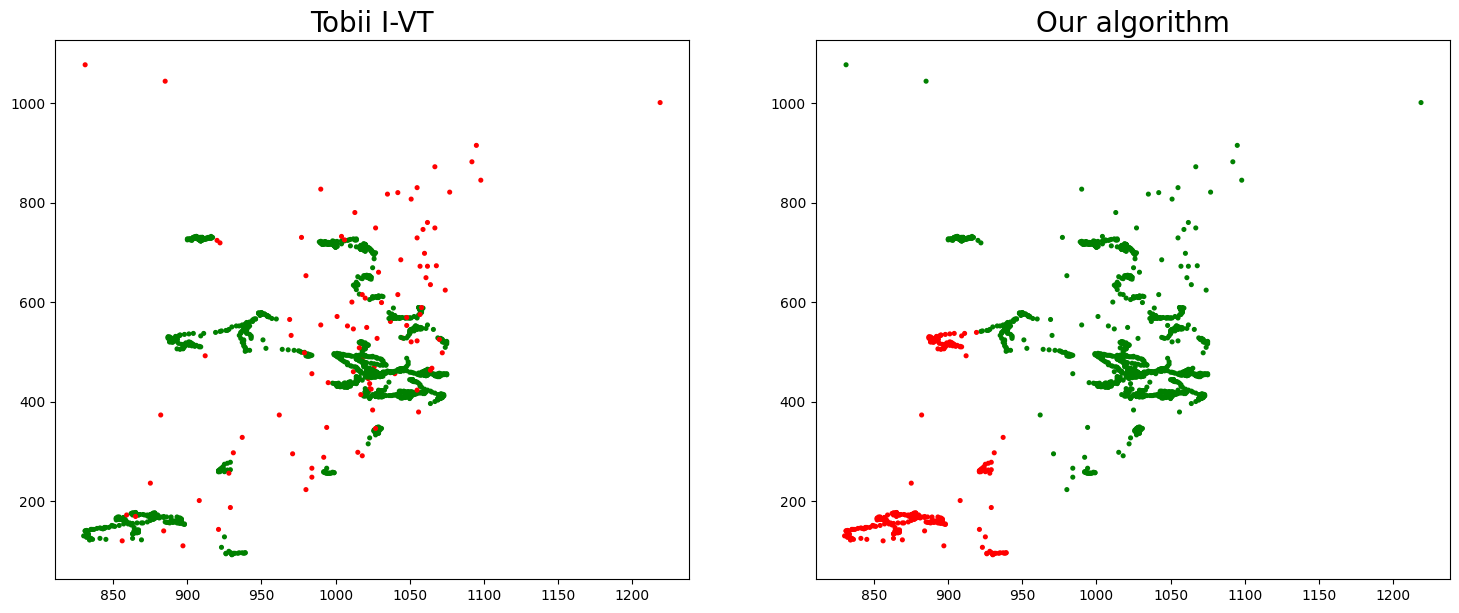

In [137]:
# Task 3. Plot your results and explore your results
original_colors = ['green' if x == 'Fixation' else 'red' for x in df_et_cleaned['Eye movement type']]
our_colors = ['green' if x == 'Fixation' else 'red' for x in events]
fig, ax = plt.subplots(ncols=2, figsize=(18,7))
ax[0].scatter(df_et_cleaned['Gaze point X'], df_et_cleaned['Gaze point Y'], color=original_colors, s=7)
ax[1].scatter(df_et_cleaned['Gaze point X'], df_et_cleaned['Gaze point Y'], color=our_colors, s=7)
ax[0].set_title('Tobii I-VT', fontdict={'fontsize':20})
ax[1].set_title('Our algorithm', fontdict={'fontsize':20})

**Task 4.** Discussion

1. How different threshold values affect detection results  
**View**:
Different threshold values seems to have different effects on the outcome of the detection. A threshold value of 5 reflected a detection of fixations in the lower end of the visual field using our algotithm while aa threshold value of 10 semmed to have the opposite effect with fixations detected in the upper area of the visual field.

2. Where our algorithm and the Tobii's algorithm results differ the most
**View**:
The Tobbi algorithm was able to detect fixations dispersed across the visual field but our algorithm only succeded in detecting fixations skewed to the lower half of the visual field. Even, went as far as classifying saccadic jumps as fixations as well.

The algorithm seemed to perform poorly on this data and it could be for a number of reasons, including poor suitability. The model has been trained on the same data over 1000 epochs that it was tested on (in-sample testing). This may have brought about overfitting as the model could have memorized the training data and failed to learn the underlying patterns. As such, this model would be unable to generalize.

It appears we may benefit from using a simpler algorithm for this use case.

3. The implications of points 1. and 2. on designing and conducting experiments
**View**:
Threshold values are peculiar to different experiemnts. Calculating an average duration for fixations in an experiment may be an ideal way to settle on a threshold value for event detection or using a perceived value based on intuition or an informed guess depending on the particular factors surrounding the experiment.
